<a href="https://colab.research.google.com/github/vopstalf/ML-Training-TE/blob/main/CNN_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Beginner Workshop: CNNs for detecting weld defects

**Goal:**

- Apply CNNs to a real industrial inspection problem
- Understand training behavior, not just final accuracy
- Progress from simple CNN → adequate-performing model

This notebook was created by Filip Van Opstal.

---

## 0. Setup (run this first)

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

---

## 1. Problem Description

🎯 Goal

Translate an inspection task into ML terms.

Input: X-ray image of a weld

Output:

*   0 → sound weld
*   1 → defective weld

Constraints:

*   Limited labeled data
*   Visual noise
*   False negatives are critical

🎯 **Task:** classify welds as defective or sound from X-ray image.

---

## 2. Download & Explore Radiographic Weld Data (RIAWELC)

RIAWELC is a public dataset of radiographic (X-ray) images of welded joints, created for research on automated weld defect recognition.

It is commonly used to benchmark CNN-based inspection systems and is well suited for hands-on learning.

Dataset characteristics

-  Modality: X-ray images of welds

-  Application: Non-Destructive Testing (NDT)

Defect types include:

-  Porosity (PO)

-  Cracks (CR)

-  Lack of penetration (LP)

-  No defect / sound weld (ND)

In [8]:
import os

DATA_ROOT = "/content/RIAWELC"
os.makedirs(DATA_ROOT, exist_ok=True)

# Clone the dataset repository
!git clone https://github.com/stefyste/RIAWELC.git $DATA_ROOT

!apt-get update -qq
!apt-get install -y unrar

RAW_ARCHIVE_DIR = "/content/RIAWELC/Dataset_partitioned"

!unrar x $RAW_ARCHIVE_DIR/RIAWELC_dataset.part01.rar $RAW_ARCHIVE_DIR

Streaming output truncated to the last 5000 lines.
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S1_[9][36].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[27][11].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[27][15].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[28][12].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[2][1].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[4][16].png      79%  OK 
Extracting  /content/RIAWELC/Dataset_partitioned/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S2_[4][20].png      79%  OK 
Extractin

The original RIAWELC weld dataset is organized by defect type.
For this exercise, we first simplify the problem to a binary classification task:

sound/ → welds without defects

defective/ → welds with any type of defect

This is a common engineering workflow to start with a coarse decision (“defect or no defect”) before moving to finer defect classification.

The preparation step below:

-  Merges all defect categories into a single defective class

-  Creates a standard folder structure compatible with PyTorch’s ImageFolder
-  Merges both the original train and test splits, so we can decide on our own split

In [9]:
import shutil

RAW_ROOT = "/content/RIAWELC/Dataset_partitioned/DB - Copy/"
CLEAN_ROOT = "/content/RIAWELC_binary"

sound_dir = os.path.join(CLEAN_ROOT, "sound")
defect_dir = os.path.join(CLEAN_ROOT, "defective")

os.makedirs(sound_dir, exist_ok=True)
os.makedirs(defect_dir, exist_ok=True)

# ---- CLASS MAPPING (based on actual folder names) ----
SOUND_CLASSES = ["NoDifetto"]
DEFECT_CLASSES = ["Difetto1", "Difetto2", "Difetto4"]

splits = ["training", "testing"]

for split in splits:
    split_path = os.path.join(RAW_ROOT, split)

    # Copy sound welds
    for cls in SOUND_CLASSES:
        cls_path = os.path.join(split_path, cls)
        if not os.path.exists(cls_path):
            raise FileNotFoundError(f"Missing class folder: {cls_path}")
        for f in os.listdir(cls_path):
            shutil.copy(os.path.join(cls_path, f), sound_dir)

    # Copy defective welds
    for cls in DEFECT_CLASSES:
        cls_path = os.path.join(split_path, cls)
        if not os.path.exists(cls_path):
            raise FileNotFoundError(f"Missing class folder: {cls_path}")
        for f in os.listdir(cls_path):
            shutil.copy(os.path.join(cls_path, f), defect_dir)

## Intermezzo: Let's have a look at some of the defective weld pictures!

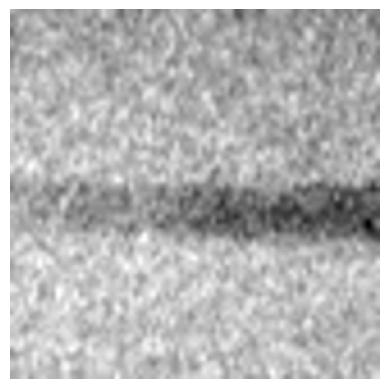

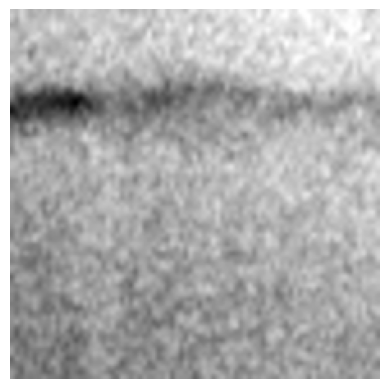

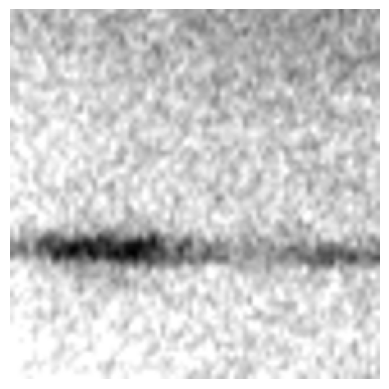

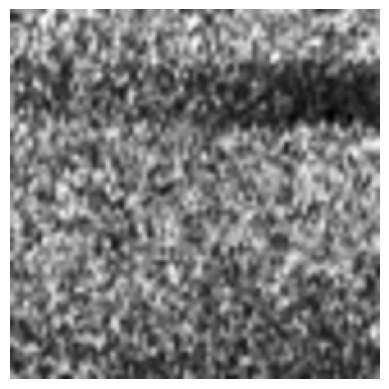

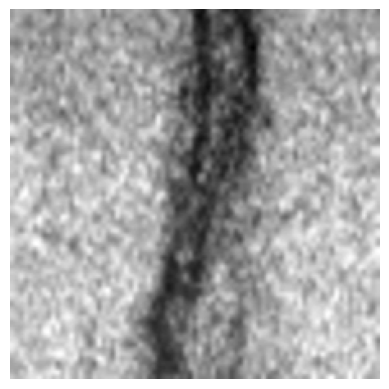

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(folder, n=5):
    images = os.listdir(folder)[:n]
    for img_name in images:
        img = Image.open(os.path.join(folder, img_name))
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.show()

show_samples(f"{CLEAN_ROOT}/defective")

---

## 3. Dataset and DataLoader

Neural networks do not work directly with files on disk.
In PyTorch, the Dataset defines how individual samples are read and transformed, while the DataLoader controls how data is batched and fed to the network during training.

In this step we:

-  Use ImageFolder, which automatically assigns labels based on folder names (sound/, defective/)

-  Apply basic image preprocessing (resize and tensor conversion)

-  Split the data into training and validation sets

-  Create DataLoaders to handle batching, shuffling, and efficient loading

In [11]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [12]:
dataset = ImageFolder(CLEAN_ROOT, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

---
## 4. Baseline CNN Model, Loss Function, and Optimizer

In this step, we define a **minimal Convolutional Neural Network (CNN)**.  
The objective is **not maximum performance**, but to create a **clear and understandable baseline** that allows us to reason about CNN behavior.

This baseline will later be improved step by step.

---

### 🔷 Model Architecture (Baseline CNN)

The network consists of:
- Two **convolution + activation + pooling** blocks  
- One **fully connected layer** producing a single output


---

### 📐 Input and Output Sizes

#### Input
- Images are resized to **224 × 224 pixels**
- RGB images → **3 channels**
- Input tensor shape:

\[
(N\; 3\; 224\; 224)
\]

where `N` is the batch size.

---

### 🔹 Convolution Output Size Formula

For a convolution layer:

$$
H_{out} = \frac{H_{in} + 2P - K}{S} + 1
$$

where:
- \(H_{in}\) = input height (or width)
- \(K\) = kernel size
- \(P\) = padding
- \(S\) = stride

We use **3×3 kernels**, **padding = 1**, **stride = 1**,  
so the spatial resolution is preserved **before pooling**.

---

### 🔹 Effect of Max Pooling

Each **2×2 MaxPooling layer** reduces the spatial dimensions by a factor of 2:

$$
H_{out} = \frac{H_{in}}{2}
$$

---

### 📊 Size Evolution Through the Network

| Stage | Channels | Height × Width |
|------|----------|----------------|
| Input | 3 | 224 × 224 |
| After Conv1 + Pool | 16 | 112 × 112 |
| After Conv2 + Pool | 32 | 56 × 56 |
| Flatten | – | 32 × 56 × 56 |
| Fully Connected | – | 1 |

The fully connected layer receives:

$$
32 \times 56 \times 56 = 100{,}352 \text{ features}
$$

---

### 🔢 Model Output

- The model outputs **one raw value (logit)** per image
- This value represents confidence that the weld is **defective**
- No sigmoid activation is applied inside the model

---

### 📉 Loss Function: `BCEWithLogitsLoss`

We use **Binary Cross-Entropy with Logits**, which is the standard loss for **binary classification**.

Why this loss:
- Combines **sigmoid activation + cross-entropy** in a numerically stable way
- Avoids manual probability conversion
- Well suited for binary CNN outputs

The loss compares:
- Model output (logit)
- Ground-truth label (`0 = sound`, `1 = defective`)

---

### ⚙️ Optimizer: Adam

We use the **Adam optimizer** with a small learning rate.

Why Adam:
- Automatically adapts learning rates per parameter
- Works well with noisy gradients and small datasets
- Requires minimal tuning for baseline experiments

Adam is a common **default optimizer** for CNN prototyping.


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

In [14]:
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

---
## 5. Training Loop

At each epoch:

-  The model processes batches of images

-  Predictions are compared to ground-truth labels using the loss function

-  Gradients are computed and used to update model parameters

-  Performance is evaluated on unseen validation data

By tracking loss and accuracy across epochs, we can see how learning evolves, not just the final result.

In [15]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.float().to(device)
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [16]:
def eval_epoch(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = torch.sigmoid(model(x).squeeze()) > 0.5
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [17]:
EPOCHS = 10

train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_acc = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Accuracy: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.4604 | Val Accuracy: 0.7482
Epoch 2/10 | Train Loss: 0.4374 | Val Accuracy: 0.7561
Epoch 3/10 | Train Loss: 0.4255 | Val Accuracy: 0.7605
Epoch 4/10 | Train Loss: 0.4171 | Val Accuracy: 0.8033
Epoch 5/10 | Train Loss: 0.4429 | Val Accuracy: 0.7482
Epoch 6/10 | Train Loss: 0.4087 | Val Accuracy: 0.8210
Epoch 7/10 | Train Loss: 0.4106 | Val Accuracy: 0.7784
Epoch 8/10 | Train Loss: 0.4029 | Val Accuracy: 0.8068
Epoch 9/10 | Train Loss: 0.4016 | Val Accuracy: 0.8169
Epoch 10/10 | Train Loss: 0.3852 | Val Accuracy: 0.8415


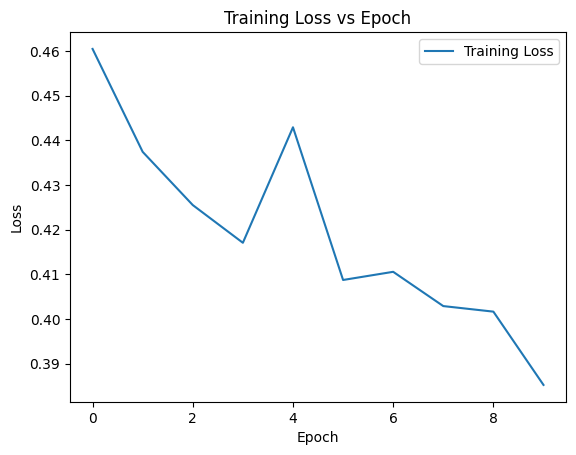

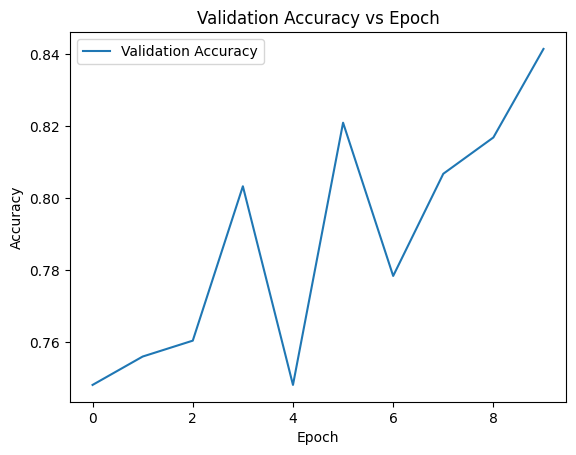

In [18]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epoch")
plt.legend()
plt.show()

## 6. Improve with Data Augmentation

### 🎯 Goal
Increase model robustness **without changing the network architecture**.

---

### 🔄 Why Data Augmentation?

Data augmentation artificially increases dataset diversity by applying **random transformations** to training images.

This helps the model:
- Become less sensitive to small variations
- Generalize better to unseen data
- Reduce overfitting

📌 *Only the **training data** is augmented.  
Validation data must remain unchanged.*

---

### 🧪 Training Data Augmentation

We apply simple, physically meaningful transformations:
- Small rotations
- Horizontal flips
- Resize and tensor conversion

In [19]:
# Augmentation applied ONLY to training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Validation data: no augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

### 📦 Recreate Dataset and DataLoaders

Because transforms are applied at the Dataset level, we must **recreate the dataset and dataloaders** for augmentation to take effect.

In [21]:
# Recreate dataset with different transforms
train_dataset = ImageFolder(CLEAN_ROOT, transform=train_transform)
val_dataset   = ImageFolder(CLEAN_ROOT, transform=val_transform)

# Train / validation split
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

---
## 7. Better CNN Architecture

Improve representational capacity safely.

Improvements:

-  BatchNorm

-  Dropout

-  More channels

In [22]:
class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 56 * 56, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [23]:
model = BetterCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
EPOCHS = 10

train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_acc = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Accuracy: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 2.5075 | Val Accuracy: 0.7255
Epoch 2/10 | Train Loss: 1.1154 | Val Accuracy: 0.7718
Epoch 3/10 | Train Loss: 0.4985 | Val Accuracy: 0.8692
Epoch 4/10 | Train Loss: 0.3664 | Val Accuracy: 0.8459
Epoch 5/10 | Train Loss: 0.3140 | Val Accuracy: 0.8878
Epoch 6/10 | Train Loss: 0.2991 | Val Accuracy: 0.8809
Epoch 7/10 | Train Loss: 0.2902 | Val Accuracy: 0.8771
Epoch 8/10 | Train Loss: 0.2831 | Val Accuracy: 0.8260
Epoch 9/10 | Train Loss: 0.2720 | Val Accuracy: 0.8771
Epoch 10/10 | Train Loss: 0.2748 | Val Accuracy: 0.8399


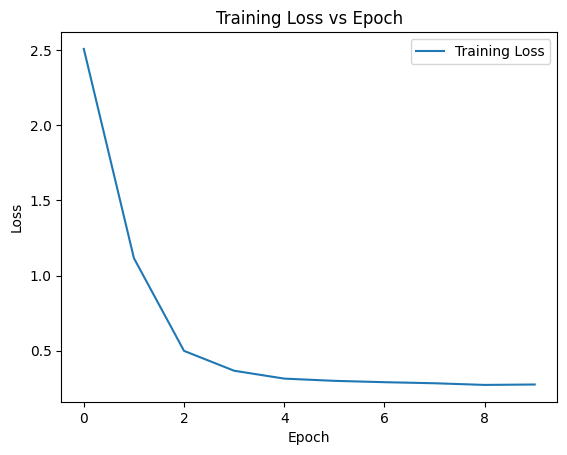

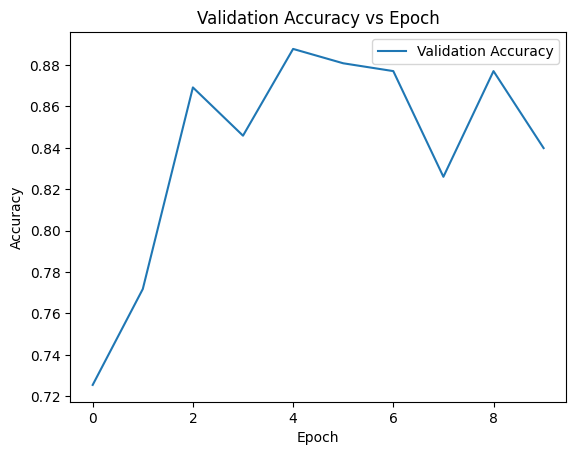

In [26]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epoch")
plt.legend()
plt.show()

---
## 8. Transfer Learning

### 🎯 Goal
Leverage knowledge learned from large datasets to improve performance on a limited industrial dataset.

---

### 🔁 What Is Transfer Learning?

Transfer learning uses a **pretrained convolutional network** as a starting point instead of training from scratch.

The pretrained model has already learned:
- Edge detectors
- Texture patterns
- Shape and object-level features

These features are **generic visual primitives** that transfer well across domains, including industrial X-ray imagery.

---

### 🧠 What Is ResNet Pretrained On?

ResNet models provided by PyTorch are pretrained on **ImageNet**, a large-scale dataset containing:
- Over **1 million images**
- **1000 object categories**
- Natural images (animals, vehicles, everyday objects)

Although ImageNet does **not** contain X-ray images, the early and mid-level features learned by the network are still highly useful for defect detection tasks.

---

### 🧠 How We Apply It Here

- We load a pretrained ResNet (e.g. ResNet18)
- We replace the final classification layer with a **binary classifier**
- We can:
  - **Freeze** the pretrained backbone and train only the new head
  - **Fine-tune** all layers for higher performance

---

### 📌 Why Transfer Learning Works Well

- Faster convergence
- Better generalization
- Reduced overfitting
- Strong performance even with small datasets

> In practice, training CNNs from scratch is the exception — not the rule.

In [28]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

# Freeze pretrained backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer (binary classification)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 59.6MB/s]


In [ ]:
EPOCHS = 10

train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_acc = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Accuracy: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.6864 | Val Accuracy: 0.5626
Epoch 2/10 | Train Loss: 0.6851 | Val Accuracy: 0.5459


In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transfer Learning – Training Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transfer Learning – Validation Accuracy")
plt.legend()
plt.show()

## 9. Model Evaluation with Confusion Matrix

### 🎯 Goal
Go beyond accuracy and understand **how** the model makes mistakes.

---

### 🔍 Why a Confusion Matrix?

Accuracy alone hides important information.
The **confusion matrix** shows how predictions are distributed across classes:

- True Positives (TP): defective welds correctly detected
- True Negatives (TN): sound welds correctly identified
- False Positives (FP): sound welds flagged as defective
- False Negatives (FN): defective welds missed by the model

📌 *In industrial inspection, False Negatives are often more critical than False Positives.*

---

### 🧠 Evaluation Metrics

From the confusion matrix we derive:

- **Accuracy**  
  Overall correctness

- **Precision**  
  How reliable defect detections are  
  (low precision → many false alarms)

- **Recall (Sensitivity)**  
  How many real defects are found  
  (low recall → missed defects)

- **F1-score**  
  Balance between precision and recall

---

### 📦 Compute Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and labels
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Sound", "Defective"],
    yticklabels=["Sound", "Defective"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Transfer Learning Model")
plt.show()

In [ ]:
### 📈 Classification Report

In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Sound", "Defective"]
))